# Are you the one - Monte Carlo simulation of two strategies

## Rules

At the beginning of the competition, for 10 men and 10 women, their "optimal" partner according to scientific criteria are found. The contestants don't know who their perfect match is.

In successive weeks/ rounds, the contestants have to match up in couples that they can chose themselves. At the end of each week, the contestants will get to know how many of the chosen matchups were correct, but they don't get to know which ones were correct. In addition, after this information is given, they are allowed to send one couple to the truth booth and they will find out for this couple whether the couple is a perfect match or not. The couple that is sent to the truth booth can be chosen freely (i.e. we can chose a couple that was paired up together before, or we can also chose a couple that was never paired up before).

If the contestants manage to find all of the perfect matches by the end of round 10, they will share a price of 1 Mio USD.

## Methodology

This is an attempt to simulate different strategies and hence to find out how likely these strategies are to find the correct couple within 10 weeks.

First, let's import the necessary modules: a method to randomly shuffle a list and Model from docplex, which is used to solve systems of linear equations. We will also set a random seed to make the results 100% reproducible.

Setting a random seed is optional, but you might then get slightly different numbers.

In [1]:
from random import shuffle, seed
from docplex.mp.model import Model

seed(1)

Next, let's define an abstract strategy class. A strategy needs to be able to take two types of decisions:

1. Which couples will be chosen for the next round
2. Which couple is sent to the truth booth at the end of each round

For each of these tasks, the strategy gets some basic information:

1. The pairs that have been correctly identified as perfect matches alreaady
2. The pairs that have been identified as a non-perfect match in the truth booth
3. The matchups of the previous rounds
4. The number of perfect matches in each round

In [2]:
class Strategy:
    
    def get_next_pairs(self, known_pairs, known_not_pairs, previous_pairs, previous_correct):
        pass
    
    def get_truth_booth_pair(self, pairs, known_pairs, known_not_pairs, previous_pairs, previous_correct):
        pass

A first strategy (Strategy 1) is trying to simulate what the contestants do in real life. That means, that the couples are chosen randomly and that we only take into account basic information (confirmed and unconfirmed couples). Like the contestants in real life, this strategy doesn't really knoow what to do with the information about the previous rounds and the number of correct perfect matches in each of those rounds:

In [3]:
class Strategy1(Strategy):
    """ This is a very naive strategy, but close to what the actual contestants are doing:
        Couples are formed randomly in every round. The only information that is considered when forming
        the couples is the couples that have been confirmed/ not confirmed by the truth booth. Furthermore,
        if the matchmaking ceremony reveals that we have no new couples, these couples are also avoided in the future.
        Couples are chosen randomly for the truth booth. In the event that we know that there are no couples 
        (since the truth booth is after the matchmaking ceremony), we send a new couple to the truth booth to increase 
        our chances to get valuable information. 
    """
    
    def get_next_pairs(self, n_couples, known_pairs, known_not_pairs, previous_pairs, previous_correct):
        # always first set the pairs that already known and then randomly chose the other pairs without chosing any pairs that have previously been identified as non-matching
        pairs = known_pairs[:]
        men = list(range(n_couples))
        women = list(range(n_couples))
        used_men = [c[0] for c in pairs]
        used_women = [c[1] for c in pairs]
        available_men = [m for m in men if m not in used_men]
        available_women = [w for w in women if w not in used_women]
        fail_count = 0
        while len(pairs) < n_couples:
            shuffle(available_men)
            shuffle(available_women)
            if (available_men[-1], available_women[-1]) not in known_not_pairs:
                pairs.append((available_men.pop(), available_women.pop()))
                used_men.append(pairs[-1][0])
                used_women.append(pairs[-1][1])
            else:
                fail_count += 1
            if fail_count > 300: # if there have been too many failed attempts to form the couples, lets start over again
                fail_count = 0
                pairs = known_pairs[:]
                men = list(range(n_couples))
                women = list(range(n_couples))
                used_men = [c[0] for c in pairs]
                used_women = [c[1] for c in pairs]
                available_men = [m for m in men if m not in used_men]
                available_women = [w for w in women if w not in used_women]
        return pairs
    
    def get_truth_booth_pair(self, pairs, known_pairs, known_not_pairs, previous_pairs, previous_correct):
        shuffle(pairs)
        while pairs[0] in known_pairs:
            shuffle(pairs)
        if previous_correct[-1] == len(known_pairs): # if we know that none of the couples (apart from the already confirmed ones) are correct, we are better off sending a new couple that we don't have information on to the truth booth:
            men = list(range(len(pairs)))
            women = list(range(len(pairs)))
            shuffle(men)
            shuffle(women)
            while((men[0], women[0]) in known_pairs+known_not_pairs):
                shuffle(men)
                shuffle(women)
            return (men[0], women[0])
        return pairs[0]



An optimal strategy on the other hand is using mathematical modelling to extract as much information as possible from the information that is given and to strategically chose the "truth booth" couple in such a way that only a couple is chosen, that we don't know anything about yet.

In [4]:
class Strategy2(Strategy):
    """ This is the mathematically optimal strategy. Every bit of information that is available is used to
        chose the most likely matches at every step. This strategy is using mixed integer programming to solve 
        the system of linear equations that give information about the perfect matches.
    """
    
    def get_next_pairs(self, n_couples, known_pairs, known_not_pairs, previous_pairs, previous_correct, exclude_solution = None):
        # This method has an optional parameter "exclude_solution".
        # This parameter can be used to generate a second solution, in case one exists.
        # This can be useful to determine which pair to send to the truth booth
        m = Model()
        x = {(man, woman): m.binary_var() for man in range(n_couples) for woman in range(n_couples)}
        # couple condition - everyone has exactly one partner:
        for i in range(n_couples):
            m.add(m.sum(x[(i,j)] for j in range(n_couples)) == 1)
            m.add(m.sum(x[(j,i)] for j in range(n_couples)) == 1)
        # set the known pairs and known "not pairs"
        for pair in known_pairs:
            m.add(x[pair] == 1)
        for pair in known_not_pairs:
            m.add(x[pair] == 0)
        # Use information from matchmaking ceremony
        for i in range(len(previous_pairs)):
            m.add(m.sum(x[pair] for pair in previous_pairs[i]) == previous_correct[i])
        # Possibly exclude a solution
        if exclude_solution:
            m.add(m.sum(x[pair] for pair in exclude_solution) <= len(exclude_solution)-1)
        solution = m.solve()
        if solution:
            pairs = []
            for man in range(n_couples):
                for woman in range(n_couples):
                    if x[(man, woman)].solution_value > 0.5:
                        pairs.append((man, woman))
            return pairs
        else:
            return None
    
    def get_truth_booth_pair(self, pairs, known_pairs, known_not_pairs, previous_pairs, previous_correct):
        # Ideally, we want to send a couple to the truth booth that we are not certain about yet
        # For this persion we generate two new pairings. If only one pairing exist, we already know that we have guessed everything right.
        # Otherwise, we will take the first couple that differs between the two solutions
        pairing1 = self.get_next_pairs(len(pairs), known_pairs, known_not_pairs, previous_pairs, previous_correct)
        pairing2 = self.get_next_pairs(len(pairs), known_pairs, known_not_pairs, previous_pairs, previous_correct, pairing1)
        if not pairing2:
            return pairs[0] # if a second solution doesn't exist, we know that in the next step we will for sure get the right couples anyway, hence it doesn't matter what we return
        else:
            for p in pairing1:
                if p not in pairing2:
                    return p # Otherwise just pick the first solution that exists in pairing1 but not in pairing2
        return pairs[0]

Next, we need a framework to simulate the outcomes of these strategies. First of all, a method to generate random "perfect matches". This method only takes the number of couples and then randomly assigns a man to a woman. These are our perfect couples:

In [5]:
def generate_random_set_of_couples(n_couples):
    men = list(range(n_couples))
    women = list(range(n_couples))
    shuffle(men)
    shuffle(women)
    perfect_matches = [(men[i], women[i]) for i in range(n_couples)] 
    return perfect_matches

Then, we need a method to simulate a single "season" of AYTO:

In [6]:
def simulate_once(strategy, n_couples = 10, log_output = True):
    perfect_matches = generate_random_set_of_couples(n_couples)
    if log_output:
        print('The perfect matches are as follows')
        print(perfect_matches)
    known_pairs = []
    known_not_pairs = []
    previous_pairs = []
    previous_correct = []
    for week in range(0, 100):
        if log_output:
            print('Week %i'%week)
        # at the beginning of the week, chose the matchups
        pairs = strategy.get_next_pairs(n_couples, known_pairs, known_not_pairs, previous_pairs, previous_correct)
        
        if log_output:
            print('Chosen matchups:', pairs)
        # at the end of the episode we will know how many of the couples were perfect matches
        count = 0
        for couple in pairs:
            if couple in perfect_matches:
                count += 1
        if count == len(known_pairs):
            # In this case we know for all pairs except the ones that were identified already that they aren't perfect matches
            for couple in pairs:
                if couple not in known_pairs:
                    known_not_pairs.append(couple)
        if log_output:
            print('Correct pairs in this round: ', count)
        previous_pairs.append(pairs) # update our lists
        previous_correct.append(count)
        # at the end of the week, send one pair to the truth booth
        truth_booth_pair = strategy.get_truth_booth_pair(pairs, known_pairs, known_not_pairs, previous_pairs, previous_correct)
        match = truth_booth_pair in perfect_matches # check if the pair chosen by the strategy is a perfect match
        if log_output:
            print('Pair for the truth booth: ', truth_booth_pair)
            print('Truth booth result: ', match)
            print()
        if match:
            known_pairs.append(truth_booth_pair)
        else:
            known_not_pairs.append(truth_booth_pair)
        if count == n_couples:
            if log_output:
                print('All couples were identified correctly in week %i'%week)
            return week

Let's test this with each strategy:

In [7]:
st = Strategy1()

simulate_once(st)

The perfect matches are as follows
[(6, 4), (8, 8), (9, 2), (7, 6), (5, 5), (3, 9), (0, 0), (4, 7), (1, 1), (2, 3)]
Week 0
Chosen matchups: [(4, 6), (3, 5), (6, 9), (5, 0), (0, 1), (1, 7), (8, 2), (7, 4), (2, 8), (9, 3)]
Correct pairs in this round:  0
Pair for the truth booth:  (6, 7)
Truth booth result:  False

Week 1
Chosen matchups: [(1, 5), (9, 2), (0, 0), (3, 1), (7, 6), (5, 9), (4, 4), (6, 8), (8, 7), (2, 3)]
Correct pairs in this round:  4
Pair for the truth booth:  (5, 9)
Truth booth result:  False

Week 2
Chosen matchups: [(2, 4), (0, 7), (8, 0), (5, 2), (7, 9), (1, 3), (9, 5), (3, 6), (4, 8), (6, 1)]
Correct pairs in this round:  0
Pair for the truth booth:  (9, 9)
Truth booth result:  False

Week 3
Chosen matchups: [(8, 7), (1, 1), (0, 4), (7, 2), (3, 9), (6, 6), (2, 0), (4, 3), (9, 8), (5, 5)]
Correct pairs in this round:  3
Pair for the truth booth:  (6, 6)
Truth booth result:  False

Week 4
Chosen matchups: [(0, 6), (5, 3), (7, 7), (3, 4), (6, 5), (4, 1), (2, 0), (8, 9),

20

In this first test with the naive strategy, we wouldn't be able to identify all couples in 10 rounds.

In [8]:
st = Strategy2()

simulate_once(st)

The perfect matches are as follows
[(8, 2), (0, 0), (6, 3), (9, 6), (1, 9), (4, 7), (3, 8), (7, 5), (5, 1), (2, 4)]
Week 0
Chosen matchups: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]
Correct pairs in this round:  1
Pair for the truth booth:  (0, 9)
Truth booth result:  False

Week 1
Chosen matchups: [(0, 2), (1, 9), (2, 5), (3, 8), (4, 3), (5, 7), (6, 6), (7, 4), (8, 0), (9, 1)]
Correct pairs in this round:  2
Pair for the truth booth:  (0, 8)
Truth booth result:  False

Week 2
Chosen matchups: [(0, 1), (1, 7), (2, 8), (3, 9), (4, 3), (5, 2), (6, 6), (7, 0), (8, 5), (9, 4)]
Correct pairs in this round:  0
Pair for the truth booth:  (0, 6)
Truth booth result:  False

Week 3
Chosen matchups: [(0, 2), (1, 0), (2, 5), (3, 7), (4, 1), (5, 6), (6, 3), (7, 8), (8, 4), (9, 9)]
Correct pairs in this round:  1
Pair for the truth booth:  (1, 8)
Truth booth result:  False

Week 4
Chosen matchups: [(0, 4), (1, 2), (2, 5), (3, 1), (4, 0), (5, 7), (6, 9), (7, 6),

9

The optimal strategy on the other hand needs less than 10 weeks to identify all couples in this first experiment.

Obviously, a single experiment doesn't give a full picture, which is why we should try to repeat our experiment over and over again, to find out how frequently each scenario is. This part is what we call a Monte Carlo simulation:

In [9]:
def monte_carlo_simulation(n_couples, strategy, n_simulations = 1000):
    frequency = {i:0 for i in range(0,45)}
    for i in range(n_simulations):
        frequency[simulate_once(strategy, n_couples, log_output = False)] += 1
    return frequency

Let's first simulate strategy 1. We want to simulate 1000 seasons of AYTO to find out how many attempts are needed to find out all matches:

In [10]:
frequencies = monte_carlo_simulation(10, Strategy1(), 1000)

To find out how many of our 1000 attempts resulted in all couples being found in 10 or fewer rounds, we just have to sum up the frequencies up to 10:

In [11]:
sum(frequencies[i] for i in range(10+1))

31

In this attempt, only 3.1% of seasons would result in all of the couples being uncovered. We can also visualize this in a diagram of probabilities:

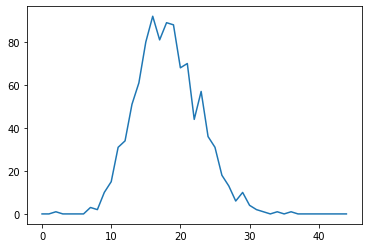

In [12]:
import matplotlib.pylab as plt

lists = sorted(frequencies.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

As we can see, in the majority of seasons it would take about 20 episodes to find all matches. We can now do the exact same experiment for the "optimal" strategy:

In 989 out of 1000 episodes all of the perfect matches are found in 10 or less weeks.


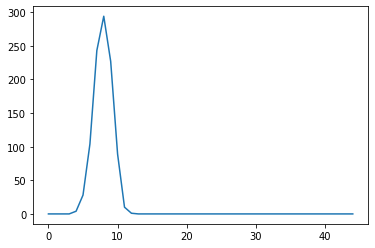

In [13]:
num_simulations = 1000
frequencies = monte_carlo_simulation(10, Strategy2(), num_simulations)
successes = sum(frequencies[i] for i in range(10+1)) # number of episodes where it takes 10 or fewer rounds to uncover all couples
print('In %i out of %i episodes all of the perfect matches are found in 10 or less weeks.'%(successes, num_simulations))

lists = sorted(frequencies.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

Strategy 2 is clearly far superior. It manages to find all perfect matches in 10 or fewer weeks in almost all cases.